In [1]:
import os
IN_KAGGLE = 'KAGGLE_URL_BASE' in os.environ
IN_KAGGLE

False

In [2]:
if IN_KAGGLE:
    from kaggle_secrets import UserSecretsClient
    user_secrets = UserSecretsClient()
    secret_value = user_secrets.get_secret("gittoken2")
    !git clone https://{secret_value}@github.com/moienr/CropMapping.git

In [3]:
if IN_KAGGLE:
    import time
    import os
    sleep_time = 5
    while not os.path.exists("/kaggle/working/CropMapping"):
        print("didn't find the path, wating {sleep_time} more seconds...")
        time.sleep(sleep_time)
    print("path found...")
    import sys
    sys.path.append("/kaggle/working/CropMapping")
    sys.path.append("/kaggle/working/CropMapping/dataset")

In [4]:
import torch
# import albumentations as A
# from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
# from model import UNET
# from utils import (
#     load_checkpoint,
#     save_checkpoint,
#     check_accuracy,
#     save_predictions_as_imgs,
# )


c:\Users\moi3n\miniconda3\envs\pytorchGPU\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
import torch
torch.__version__

'1.13.1'

In [6]:
import numpy as np
from torch.utils.data import Dataset
import torch.nn.functional as F
from glob import glob
from skimage import io
import os
from torchvision import datasets, transforms
import matplotlib
import os
import gc
import random
from datetime import date, datetime
import json
import pprint
os.cpu_count()

20

In [7]:
from model.model import DualUNet3D

In [8]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

'cuda'

In [9]:
def test_dual_unet_3d():
    print("Testing DualUNet3D...")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Device: {device}")
    s1_img = torch.randn((3, 2, 6, 64, 64)).to(device)
    s2_img = torch.randn((3, 9, 6, 64, 64)).to(device)
    model = DualUNet3D(s1_in_channels=2, s2_in_channels=9).to(device)
    preds = model(s1_img, s2_img)
    print(f"Shape of s1_img: {s1_img.shape}")
    print(f"Shape of s2_img: {s2_img.shape}")
    print(f"Shape of preds: {preds.shape}")
    print("Success!")

test_dual_unet_3d()

Testing DualUNet3D...
Device: cuda
Shape of s1_img: torch.Size([3, 2, 6, 64, 64])
Shape of s2_img: torch.Size([3, 9, 6, 64, 64])
Shape of preds: torch.Size([3, 10, 64, 64])
Success!


In [10]:
# from dataset.data_loaders import *
# from dataset.utils.utils import TextColors as TC
# from dataset.utils.plot_utils import plot_s1s2_tensors, save_s1s2_tensors_plot
# #from config import *
# from train_utils import *

In [11]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

In [12]:
from dataset.data_loaders import *
from plot import plot_train_test_losses

In [13]:
s1_transform = transforms.Compose([NormalizeS1(),myToTensor(dtype=torch.float32)])
s2_transform = transforms.Compose([NormalizeS2(),myToTensor(dtype=torch.float32)])
crop_map_transform = transforms.Compose([CropMapTransform(),myToTensor(dtype=torch.float32)])

In [1]:
# Train Paths
if IN_KAGGLE:
    s1_dir = "/kaggle/input/crop-mapping-data/s1//"
    s2_dir = "/kaggle/input/crop-mapping-data/s2//"
    crop_map_dir = "/kaggle/input/crop-mapping-data/crop_maps//"
else:
    s1_dir = "D:\\python\\CropMapping\\dataset\\ts_dataset_patched\\s1\\"
    s2_dir = "D:\\python\\CropMapping\\dataset\\ts_dataset_patched\\s2\\"
    crop_map_dir = "D:\\python\\CropMapping\\dataset\\ts_dataset_patched\\crop_map\\"
    
# Validation Paths
if IN_KAGGLE:
    s1_dir_valid = "/kaggle/input/crop-mapping-data_valid/s1//"
    s2_dir_valid = "/kaggle/input/crop-mapping-data_valid/s2//"
    crop_map_dir_valid = "/kaggle/input/crop-mapping-data_valid/crop_maps//"
else:
    s1_dir = "D:\\python\\CropMapping\\dataset\\ts_dataset_patched\\s1\\"
    s2_dir = "D:\\python\\CropMapping\\dataset\\ts_dataset_patched\\s2\\"
    crop_map_dir = "D:\\python\\CropMapping\\dataset\\ts_dataset_patched\\crop_map\\"
    
    

IndentationError: expected an indented block (3245719760.py, line 12)

In [14]:
train_dataset = Sen12Dataset(s1_dir=s1_dir,
                            s2_dir=s2_dir,
                            crop_map_dir=crop_map_dir,
                            s1_transform=s1_transform,
                            s2_transform=s2_transform,
                            crop_map_transform=crop_map_transform,
                            verbose=False)

valid_dataset = Sen12Dataset(s1_dir=s1_dir_valid,
                            s2_dir=s2_dir_valid,
                            crop_map_dir=crop_map_dir_valid,
                            s1_transform=s1_transform,
                            s2_transform=s2_transform,
                            crop_map_transform=crop_map_transform,
                            verbose=False)

In [15]:
print(train_dataset[0][0].shape, train_dataset[0][1].shape, train_dataset[0][2].shape)
print(valid_dataset[0][0].shape, valid_dataset[0][1].shape, valid_dataset[0][2].shape)


(torch.Size([2, 6, 64, 64]),
 torch.Size([10, 6, 64, 64]),
 torch.Size([21, 64, 64]))

In [16]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=4, shuffle=True, num_workers=2)

In [17]:
len(train_loader)

57

In [18]:
model = DualUNet3D(s1_in_channels=2, s2_in_channels=10, out_channels=21,ts_depth=6,use_softmax=True).to(DEVICE)

In [19]:
def train_step(model, train_loader, criterion, optimizer, epoch, verbose=True):
    """
    Train the model for one epoch
    
    Args:
    - model: the model to train
    - train_loader: the data loader for the training data
    - criterion: the loss function
    - optimizer: the optimizer
    - epoch: the current epoch
    
    Returns:
    - None
    """
    # Set the model to train mode
    model.train()
    train_loss = 0
    num_batches = len(train_loader)
    # Loop over the data in the train loader
    for batch_idx, (s1, s2, crop_map) in enumerate(train_loader):

        # Move the data to the device
        s1, s2, crop_map = s1.to(DEVICE), s2.to(DEVICE), crop_map.to(DEVICE)
        # print(f"s1.shape: {s1.shape}", f"s2.shape: {s2.shape}", f"crop_map.shape: {crop_map.shape}")
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(s1, s2)

        # Calculate the loss
        loss = criterion(outputs, crop_map)
        train_loss += loss.item()

        # Backward pass
        loss.backward()

        # Update the weights
        optimizer.step()

        if verbose:
            # Print the loss
            print(f'Train Epoch: {epoch} [{batch_idx * len(s1)}/{len(train_loader.dataset)} '
                f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')
        
    train_loss /= num_batches
    return train_loss


In [20]:
def valid_step(model, valid_loader, criterion):
    """
    Evaluate the model on the validation set
    
    Args:
    - model: the model to evaluate
    - valid_loader: the data loader for the validation data
    - criterion: the loss function
    
    Returns:
    - val_loss: the average validation loss
    """
    # Set the model to evaluation mode
    model.eval()

    # Initialize the loss and number of samples
    val_loss = 0.0
    num_batches = len(valid_loader)

    # Disable gradient computation
    with torch.no_grad():
        # Loop over the data in the validation loader
        for s1, s2, crop_map in valid_loader:
            # Move the data to the device
            s1, s2, crop_map = s1.to(DEVICE), s2.to(DEVICE), crop_map.to(DEVICE)

            # Forward pass
            outputs = model(s1, s2)

            # Calculate the loss
            loss = criterion(outputs, crop_map)

            # Update the loss and number of samples
            val_loss += loss.item() 


    # Calculate the average validation loss
    val_loss /= num_batches

    return val_loss


In [21]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [22]:

# train_step(model, train_loader, criterion, optimizer, 1)

In [23]:
def train(model, train_loader,valid_loader, criterion, optimizer, num_epochs):
    """
    Train the model for the specified number of epochs
    
    Args:
    - model: the model to train
    - train_loader: the data loader for the training data
    - criterion: the loss function
    - optimizer: the optimizer
    - num_epochs: the number of epochs to train for
    
    Returns:
    - None
    """
    train_loss_history = []
    val_loss_history = []
    
    progrss_bar = tqdm(range(num_epochs), desc="Training", unit="epoch")
    for epoch in progrss_bar:
        train_loss = train_step(model, train_loader, criterion, optimizer, epoch+1, verbose=False)
        vali_loss = valid_step(model, valid_loader, criterion)
        train_loss_history.append(train_loss)
        val_loss_history.append(vali_loss)
        
        progrss_bar.set_postfix({"Epoch": epoch+1, "Train Loss": train_loss, "Validation Loss": vali_loss})
    return train_loss_history, val_loss_history


In [24]:
train_loss_history, val_loss_history = train(model, train_loader,valid_loader, criterion, optimizer, 5)

Training: 100%|██████████| 5/5 [00:46<00:00,  9.35s/epoch, Epoch=5, Train Loss=2.43, Validation Loss=2.39]


In [25]:
# list to array with shape (1, len(list))
train_loss_history = np.array(train_loss_history).reshape(1, -1)
val_loss_history = np.array(val_loss_history).reshape(1, -1)

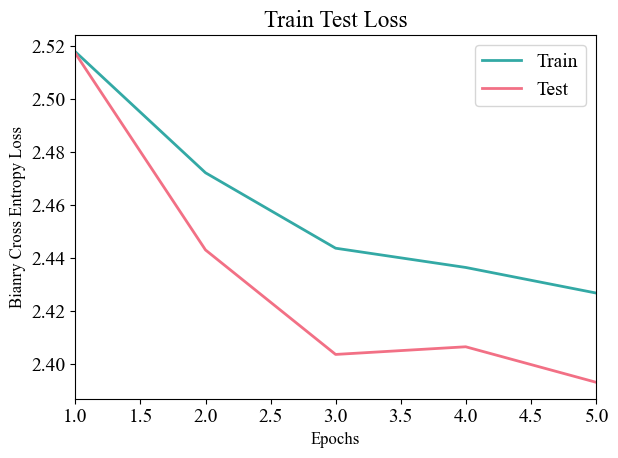

In [26]:
plot_train_test_losses(train_loss_history, val_loss_history)

In [76]:
batch = next(iter(valid_loader))
s1_img = batch[0].to(DEVICE)
s2_img = batch[1].to(DEVICE)    
crop_map = batch[2].to(DEVICE)
print(f"s1_img.shape: {s1_img.shape}", f"s2_img.shape: {s2_img.shape}", f"crop_map.shape: {crop_map.shape}")
output = model(s1_img, s2_img)
print(f"output.shape: {output.shape}")

s1_img.shape: torch.Size([4, 2, 6, 64, 64]) s2_img.shape: torch.Size([4, 10, 6, 64, 64]) crop_map.shape: torch.Size([4, 21, 64, 64])
output.shape: torch.Size([4, 21, 64, 64])


In [81]:
import matplotlib.pyplot as plt

def plot_s2_img(s2_img):
    """
    Plot an image for each depth of the s2_img tensor, by plotting the first 3 channels as an RGB image.
    
    Args:
    - s2_img: a tensor of shape (D, C, H, W)
    
    Returns:
    - None
    """
    # Move the tensor to the CPU and detach it
    s2_img = s2_img.cpu().detach()
    
    # Permute the tensor to have shape (D, H, W, C)
    s2_img = s2_img.permute(0, 2, 3, 1)
    
    # Loop over the depths and plot an image for each depth
    for d in range(s2_img.shape[0]):
        # Extract the first 3 channels as an RGB image
        rgb_img = s2_img[d, :, :, :3]
        
        # Plot the RGB image
        plt.imshow(rgb_img)
        plt.title(f"Depth {d}")
        plt.show()


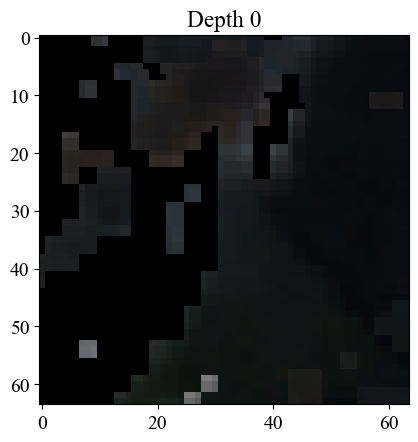

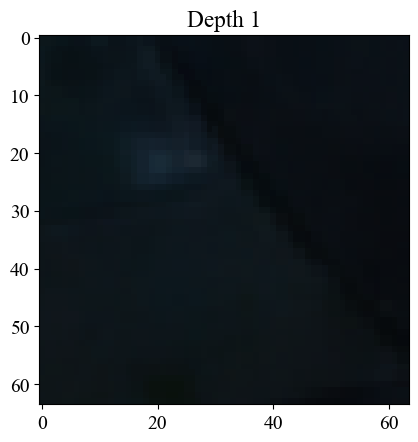

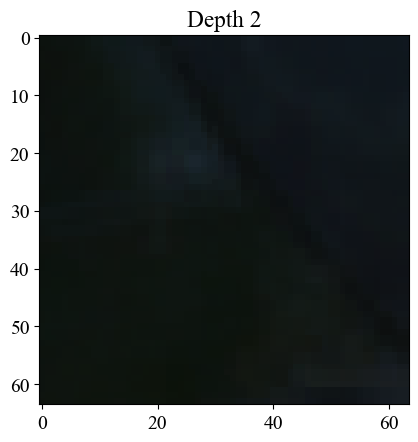

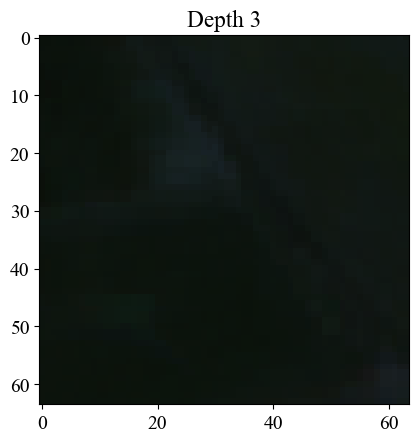

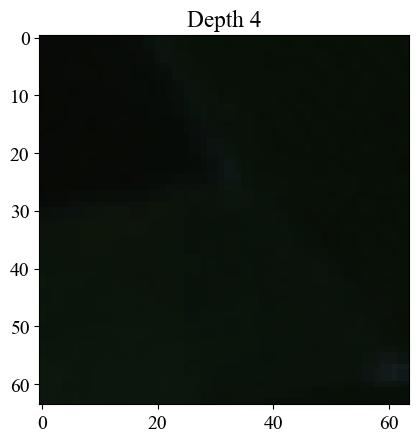

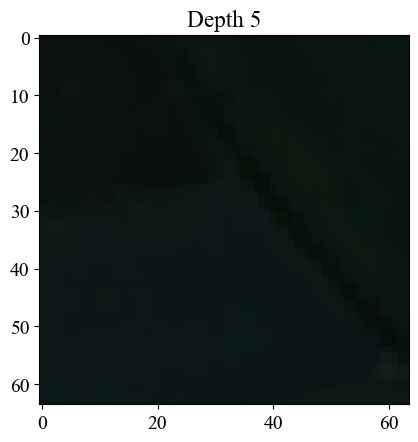

In [82]:
plot_s2_img(s2_img)

In [83]:
torch.sum(output, dim=1) # if all values are 1, then the softmax is working correctly

tensor([[[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],

        [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],

        [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.

In [84]:
output = output[0].cpu().detach().numpy()
output.shape

(21, 64, 64)

In [85]:
crop_map = crop_map[0].cpu().detach().numpy()
crop_map.shape


(21, 64, 64)

In [86]:
import matplotlib.pyplot as plt

def plot_output_crop_map(output, crop_map):
    """
    Plot the model output and crop map side by side for each band
    
    Args:
    - output: the model output tensor of shape (21, 64, 64)
    - crop_map: the crop map tensor of shape (21, 64, 64)
    
    Returns:
    - None
    """
    # Loop over the bands
    for i in range(output.shape[0]):
        # Create a figure with two subplots
        fig, axs = plt.subplots(1, 2, figsize=(10, 5))

        # Plot the model output in the first subplot
        axs[0].imshow(output[i], cmap='gray')
        axs[0].set_title(f'Band {i+1} - Model Output')

        # Plot the crop map in the second subplot
        axs[1].imshow(crop_map[i], cmap='gray')
        axs[1].set_title(f'Band {i+1} - Crop Map')

        # Show the plot
        plt.show()


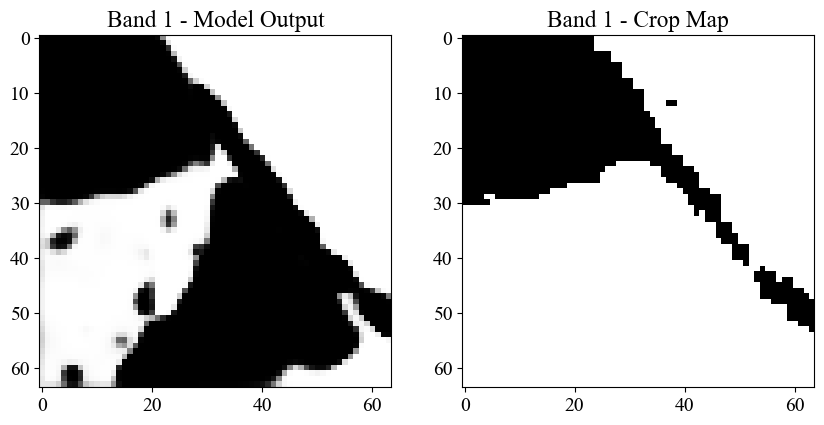

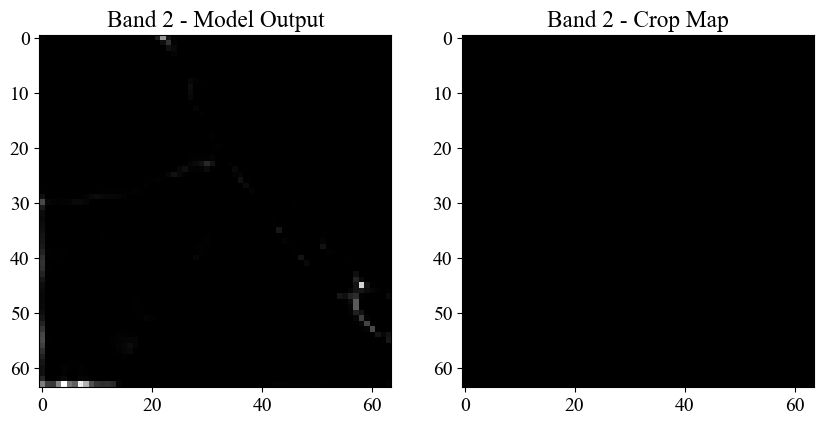

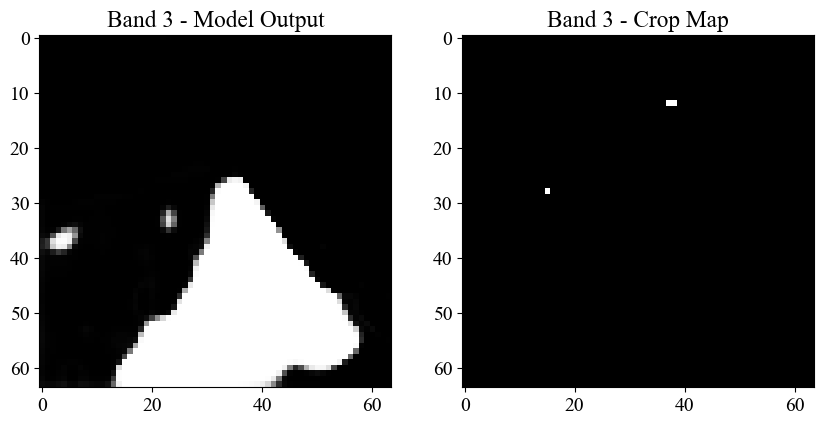

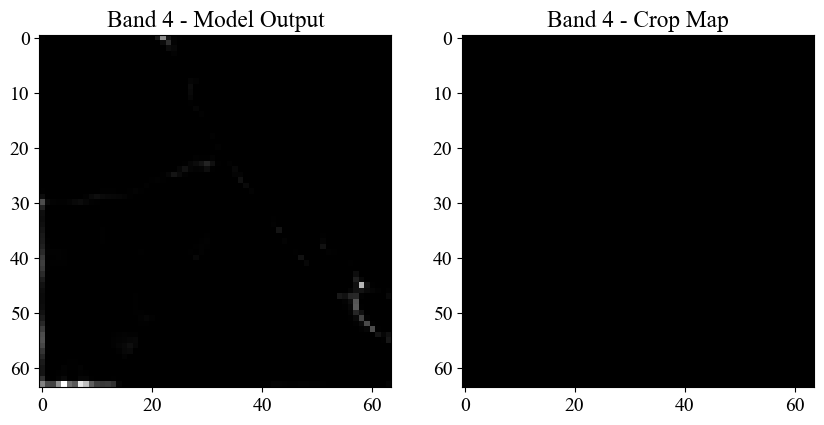

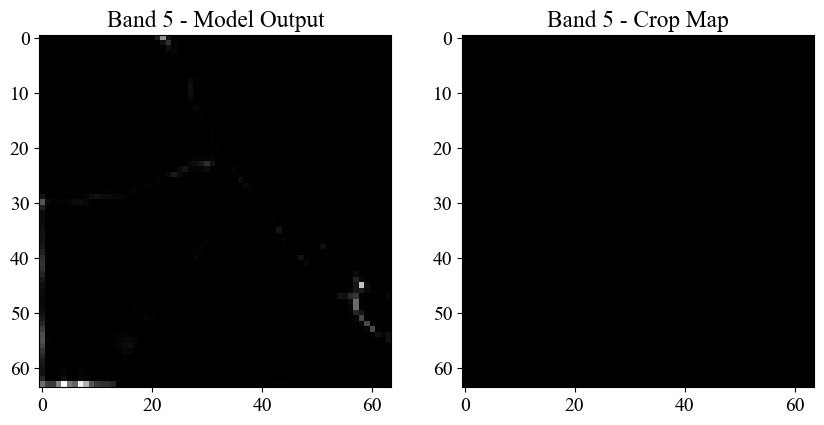

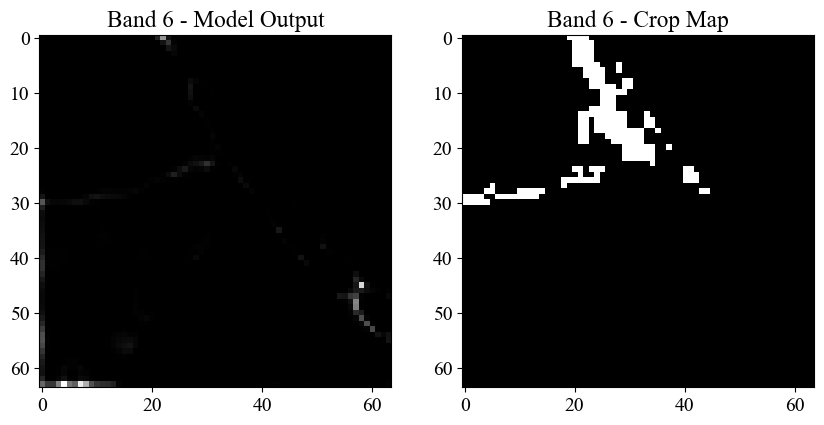

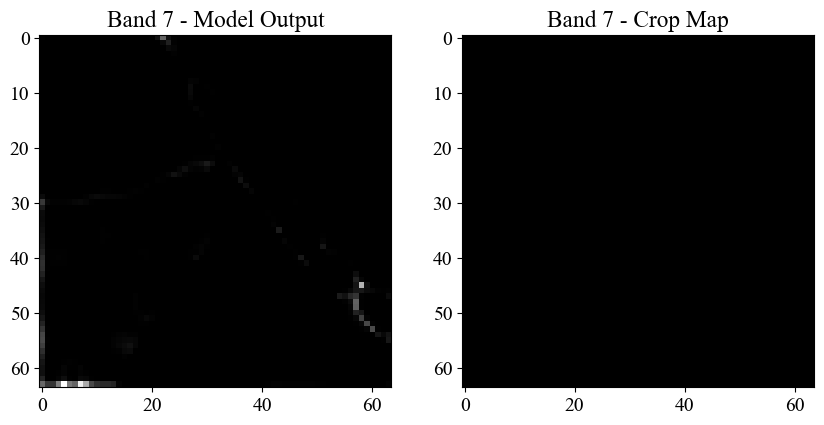

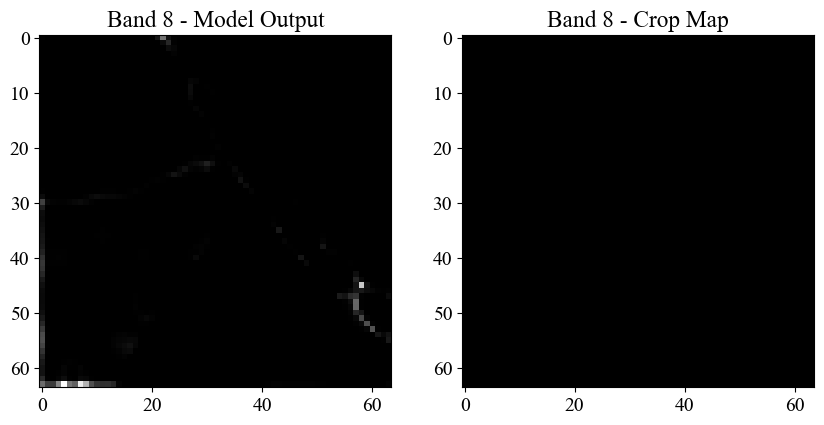

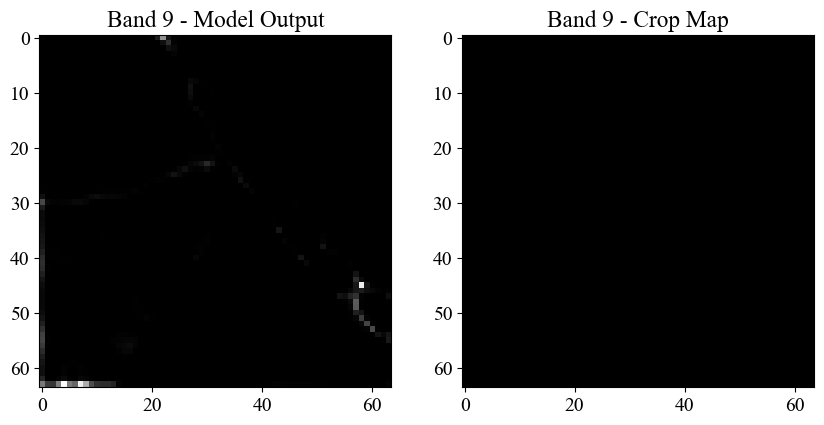

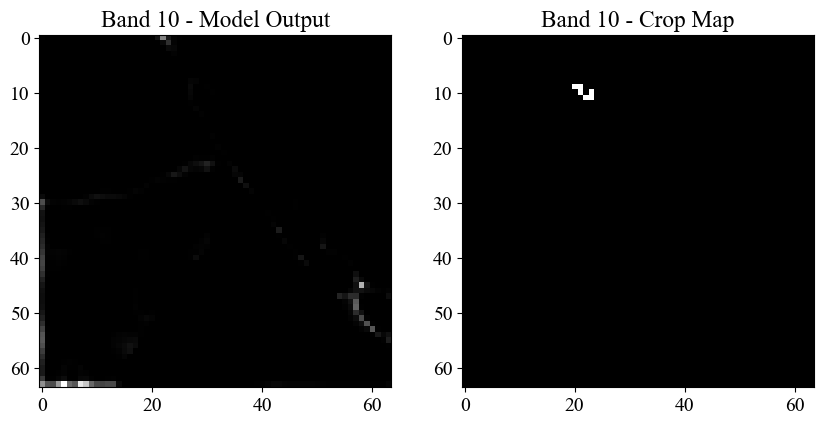

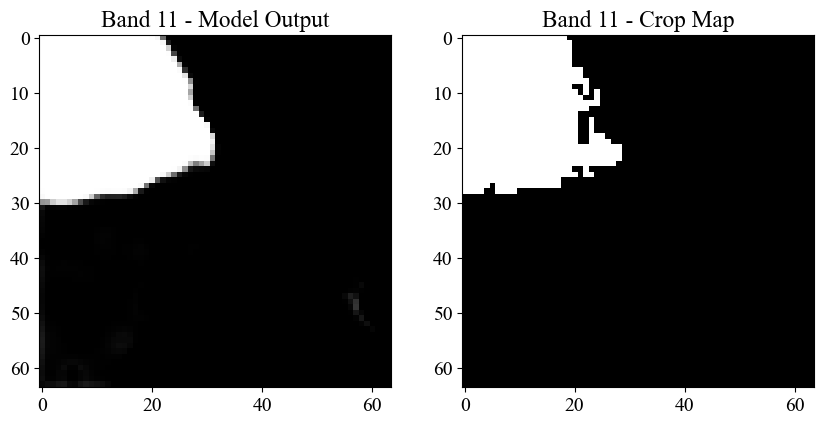

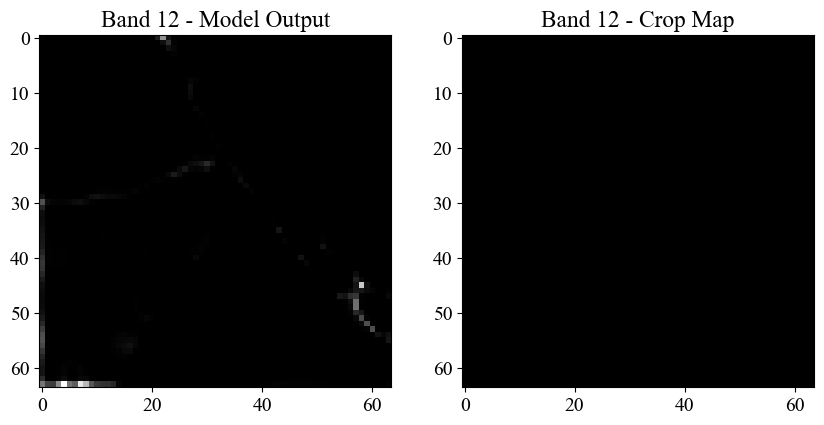

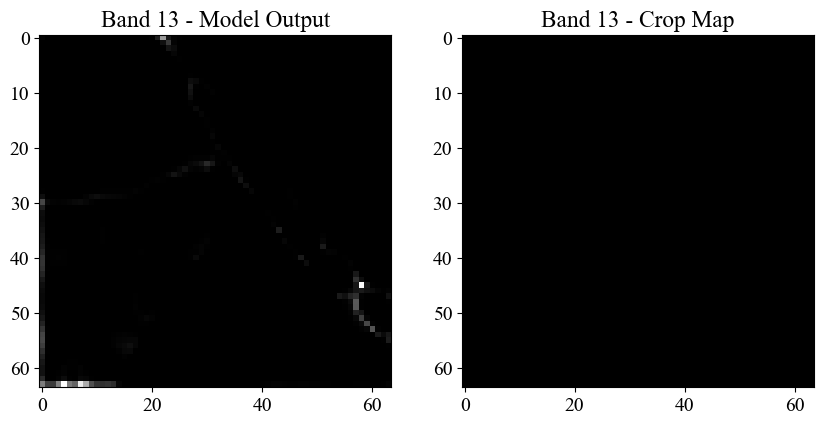

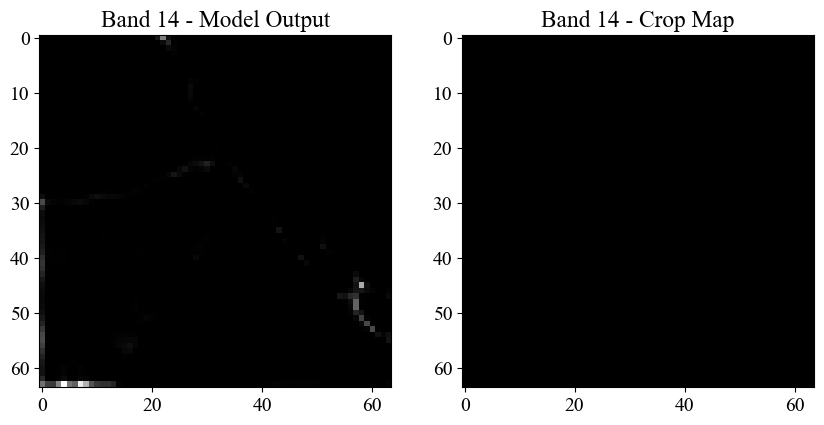

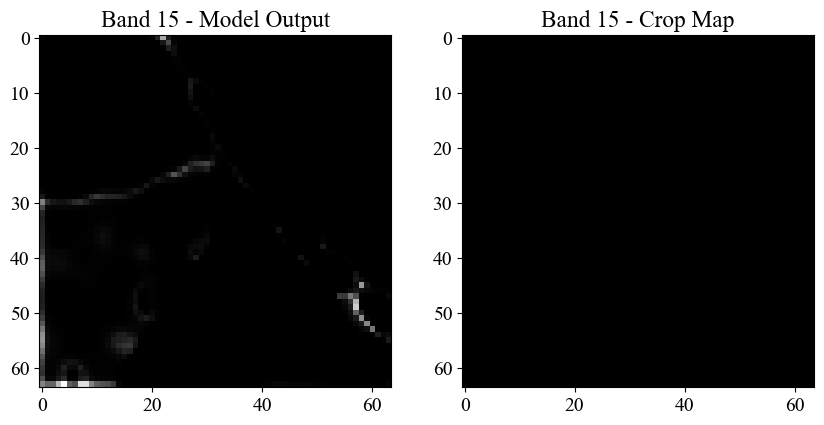

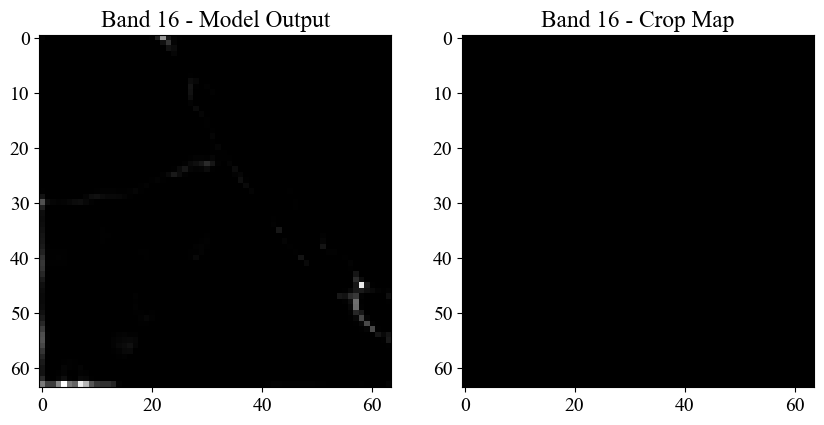

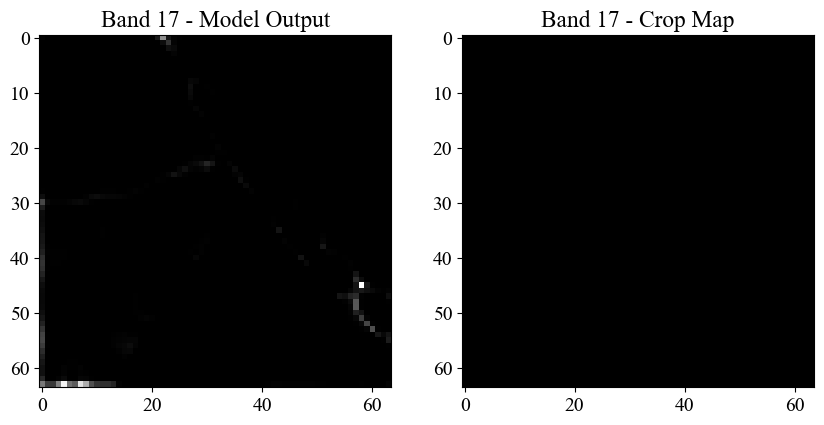

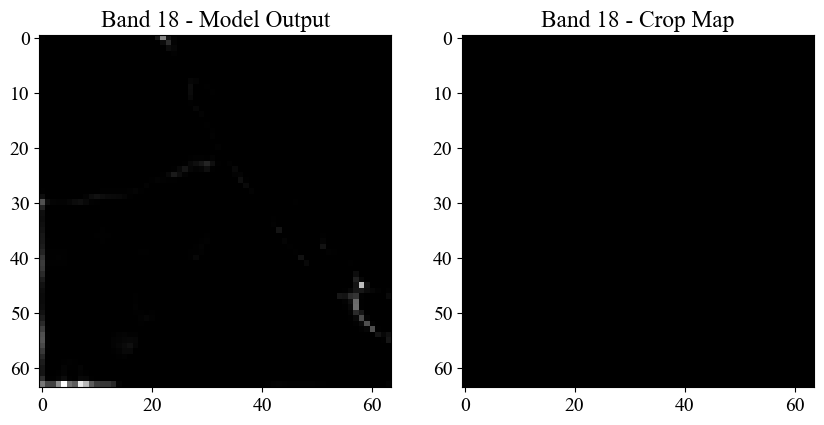

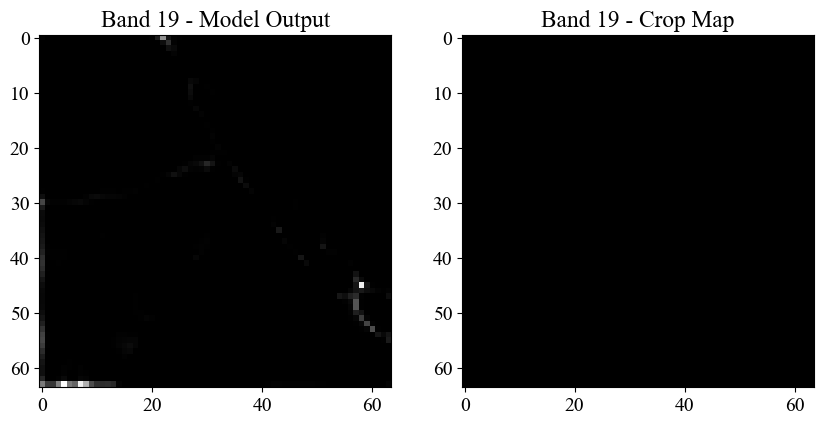

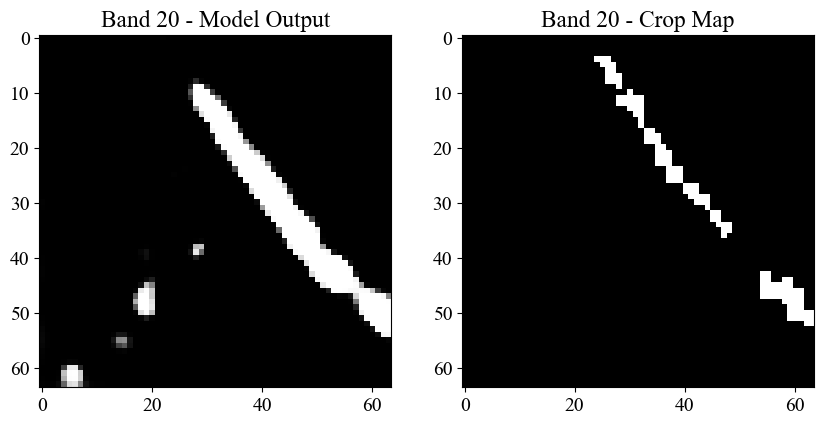

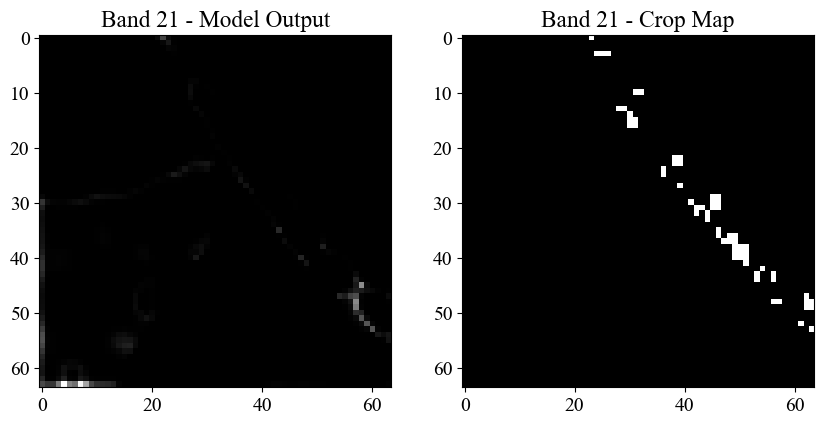

In [87]:
plot_output_crop_map(output, crop_map)